# Binary-Class Tabular Model for Raisin Grains Identification Using Python and TensorFlow
### David Lowe
### May 13, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Raisin Grains Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: In this study, the research team developed a computerized vision system to classify two different varieties of raisin grown in Turkey. The dataset contains the measurements for 900 raisin grain images. The image further broke down into seven major morphological features for each grain of raisin.

ANALYSIS: The performance of the preliminary TensorFlow model achieved an accuracy benchmark of 86.05%. When we processed the test dataset with the final model, the model achieved an accuracy score of 91.11%.

CONCLUSION: In this iteration, the TensorFlow model appeared to be suitable for modeling this dataset.

Dataset Used: Raisin Dataset

Dataset ML Model: Binary classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.30855/gmbd.2020.03.03

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed May  4 20:22:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 50
BATCH_SIZE = 32

# Define the labels to use for graphing the data
TRAIN_METRIC = "auc"
VALIDATION_METRIC = "val_auc"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.8.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-raisin-grains-dataset/Raisin_Dataset.arff'
colNames = ['Area','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent','Perimeter','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=20)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area  \
0  87524         442.246011         253.291155      0.819738        90546   
1  75166         406.690687         243.032436      0.801805        78789   
2  90856         442.267048         266.328318      0.798354        93717   
3  45928         286.540559         208.760042      0.684989        47336   
4  79408         352.190770         290.827533      0.564011        81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               900 non-null    int64  
 1   Major_Axis_Length  900 non-null    float64
 2   Minor_Axis_Length  900 non-null    float64
 3   Eccentricity       900 non-null    float64
 4   Convex_Area        900 non-null    int64  
 5   Extent             900 non-null    float64
 6   Perimeter          900 non-null    float64
 7   Class              900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [12]:
print(df_dataset_import.describe())

                Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
count     900.000000         900.000000         900.000000    900.000000   
mean    87804.127778         430.929950         254.488133      0.781542   
std     39002.111390         116.035121          49.988902      0.090318   
min     25387.000000         225.629541         143.710872      0.348730   
25%     59348.000000         345.442898         219.111126      0.741766   
50%     78902.000000         407.803951         247.848409      0.798846   
75%    105028.250000         494.187014         279.888575      0.842571   
max    235047.000000         997.291941         492.275279      0.962124   

         Convex_Area      Extent    Perimeter  
count     900.000000  900.000000   900.000000  
mean    91186.090000    0.699508  1165.906636  
std     40769.290132    0.053468   273.764315  
min     26139.000000    0.379856   619.074000  
25%     61513.250000    0.670869   966.410750  
50%     81651.000000    0.7

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Perimeter            0
Class                0
dtype: int64
Total number of NaN in the dataframe:  0


In [14]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Class').size())

Class
Besni      450
Kecimen    450
dtype: int64


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Class': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area  \
0  87524         442.246011         253.291155      0.819738        90546   
1  75166         406.690687         243.032436      0.801805        78789   
2  90856         442.267048         266.328318      0.798354        93717   
3  45928         286.540559         208.760042      0.684989        47336   
4  79408         352.190770         290.827533      0.564011        81463   

     Extent  Perimeter   target  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               900 non-null    int64  
 1   Major_Axis_Length  900 non-null    float64
 2   Minor_Axis_Length  900 non-null    float64
 3   Eccentricity       900 non-null    float64
 4   Convex_Area        900 non-null    int64  
 5   Extent             900 non-null    float64
 6   Perimeter          900 non-null    float64
 7   target             900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [17]:
print(df_dataset_import.describe())

                Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
count     900.000000         900.000000         900.000000    900.000000   
mean    87804.127778         430.929950         254.488133      0.781542   
std     39002.111390         116.035121          49.988902      0.090318   
min     25387.000000         225.629541         143.710872      0.348730   
25%     59348.000000         345.442898         219.111126      0.741766   
50%     78902.000000         407.803951         247.848409      0.798846   
75%    105028.250000         494.187014         279.888575      0.842571   
max    235047.000000         997.291941         492.275279      0.962124   

         Convex_Area      Extent    Perimeter  
count     900.000000  900.000000   900.000000  
mean    91186.090000    0.699508  1165.906636  
std     40769.290132    0.053468   273.764315  
min     26139.000000    0.379856   619.074000  
25%     61513.250000    0.670869   966.410750  
50%     81651.000000    0.7

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Perimeter            0
target               0
dtype: int64
Total number of NaN in the dataframe:  0


In [19]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Besni      450
Kecimen    450
dtype: int64


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (900, 8) df_features_import.shape: (900, 7) df_target_import.shape: (900,)


In [21]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (810, 7) df_target_train.shape: (810,)
df_features_test.shape: (90, 7) df_target_test.shape: (90,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

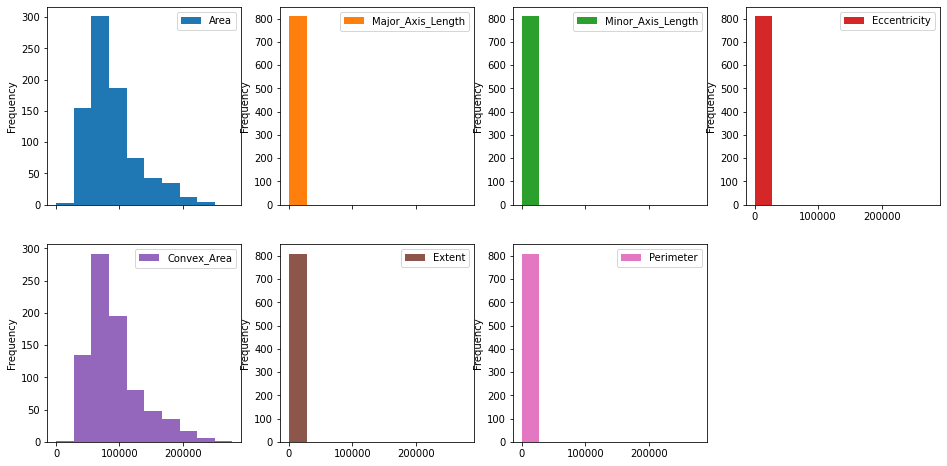

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

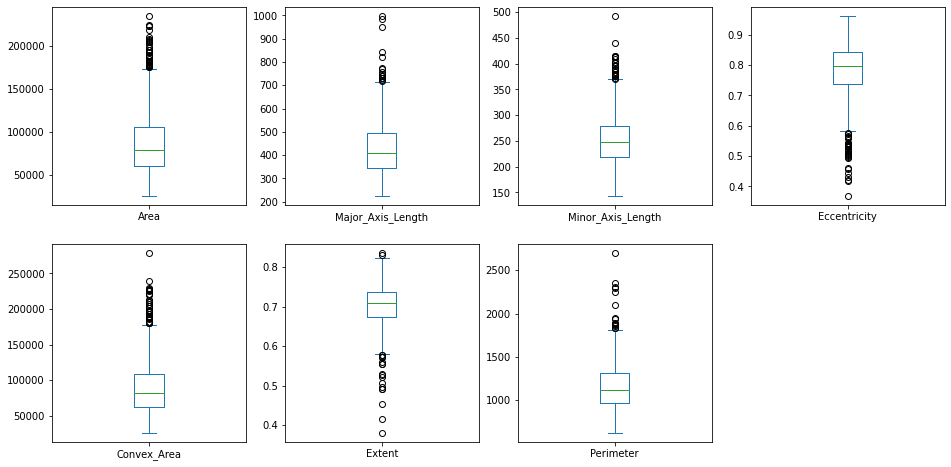

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

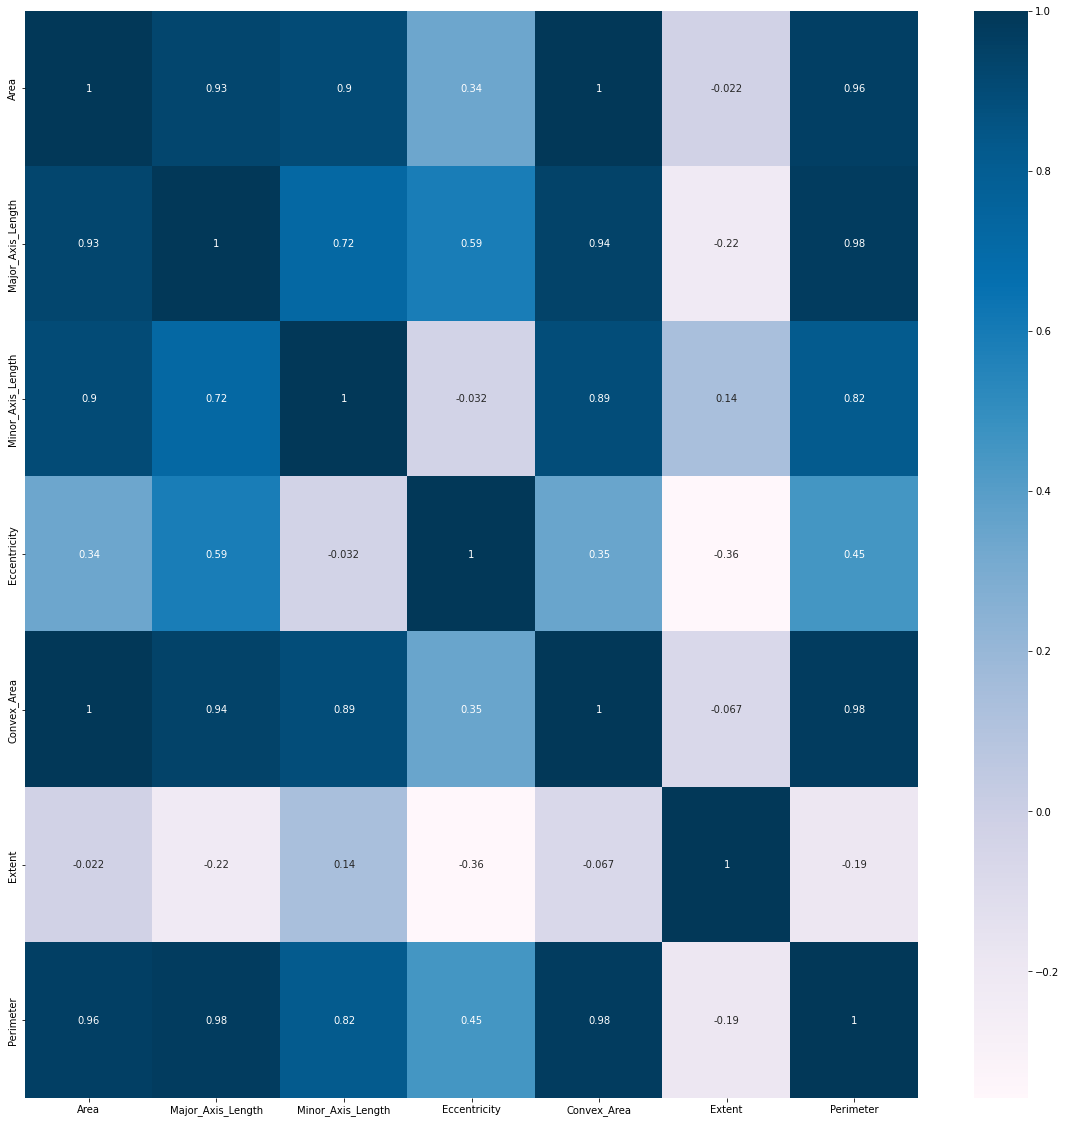

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 7
Number of categorical columns: 0
Total number of columns in the feature dataframe: 7


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (810, 7) to array_features_train.shape: (810, 7)


### 3.b) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training dataset for the modeling activities
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (810, 7) array_target_train.shape: (810,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [37]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1],
                    layer1_nodes=512, layer2_nodes=512, layer3_nodes=512, layer4_nodes=512, layer5_nodes=512,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.5, layer5_dropout=0.5,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu'),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu'),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu'),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu'),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu'),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [38]:
# # Initialize the default model and get a baseline result
# start_time_module = datetime.now()
# tf.keras.utils.set_random_seed(RNG_SEED)
# baseline_model = create_nn_model()
# baseline_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
# print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

In [39]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    tf.keras.utils.set_random_seed(RNG_SEED)
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

Score from iteration 1 >>> 0.8457
Score from iteration 2 >>> 0.8704
Score from iteration 3 >>> 0.8210
Score from iteration 4 >>> 0.8889
Score from iteration 5 >>> 0.8765
Average model score from all iterations: 0.8605 (0.0243)
Total time for model fitting and cross validating: 0:00:37.943629


### 4.b) Algorithm Tuning

In [40]:
# Not applicable for this iteration of the project

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [43]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               4096      
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)              

### 5.b) Load Test Dataset and Make Predictions

In [44]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.transform(df_target_test)
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (90, 7) array_target_test.shape: (90,)


In [45]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype("int32").ravel()
print(test_predictions)

[1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1
 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1]


In [46]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9111111111111111
ROC/AUC Score: 0.9111111111111111 

[[41  4]
 [ 4 41]] 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.91      0.91      0.91        45

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.91      0.91      0.91        90



In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:00:50.977626
